# Anime Japan

## Table of Contents

- [Part1 Introduction](#introduction)

- [Part2 2017 Top 3 Movie Markets Globally](#top3_movie_markets)

- [Part3 Comparison Analysis of Top 3 Movie Markets](#comparison)
   - [1. Preference on Movie Genres by Country](#preference_genres)
       - [1) Box Office Contributions by Movie Genres to Top 20 Movies in Each Market](#box_office_contribution_genres)
       - [2) Box Office Contributions by Key Movie Genres to Top 20 Movies in Each Market](#box_office_contribution_key_genres)
       - [3) Proportion of Animations in Top 20 Movies](#proportion_elements)
   - [2. Preference on Plots by Country](#preference_plots)
       - [1) Preference of US/Canada](#preference_us/canada)
       - [2) Preference of China](#preference_china)
       - [3) Preference of Japan](#preference_japan)
- [Appendix](#appendix)
   - [Market Share - Full Version with All Countries Shown](#market_share_full)
   - [Movie Elements Preference - Full Version with Legends](#preference_elements_full)

<a id='introduction'></a>

## Part 1 Introduction

I love watching movies, and I know that people have different tastes in movies because of their differences on culture backgrounds, characteristics and value systems. But how about on an aggregated level such as country? What are the most appreciated movies by people in different countries? Are there any differences? 

Movie Box Mojo is a website that provides up-to-date movie box office data around the world. It also has movie ranking list on domestic box office of most of major movie markets. By scraping movie data from this website and merging to the movie ranking list, we can have most of the movie summary data to do the analysis, such as genre, gross and budget.But for some foreign movies, the movie summary data are not available or complete in Movie Box Mojo's data.

So I completed the missing data by integrating IMDB's movie summary, including missing genre information of some foreign movies and all the movie plots summary.

<a id='top3_movie_markets'></a>

##  Part 2   2017 Top 3 Movie Markets Globally

First, let's choose our focus of this study based on the global ranking of movie box office.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from wordcloud import WordCloud, ImageColorGenerator
from plotly import graph_objs as go, offline as offline, plotly as py
offline.init_notebook_mode(connected=True)
% matplotlib inline

In [2]:
# read in market share data
df_market = pd.read_excel('World_movie_market_2017.xlsx', header=None, names=['country','box_office'])

In [3]:
# calculate revenue of all the other countries besides the top 3
revenue_others = df_market.box_office[3:].sum()
df_market.iloc[21,1] = revenue_others
df_market = df_market.iloc[[0,1,2,21],:]

In [4]:
colors = ['rgba(0, 109, 204, 1)', 'rgba(204, 102, 0, 1)', 'rgba(119, 204, 0, 1)']
for i in range(0,19):
    colors.append('rgba(230, 230, 230, 1)')

fig = {
  'data': [
    {
        'values': list(df_market['box_office'].values.flatten()),
        'labels': list(df_market['country'].values.flatten()),
        'marker': {'colors': colors},
        'hoverinfo':'label+percent',
        'textinfo':'label+percent',
        'textposition':'outside',
        'hole': .7,
        'type': 'pie',
        'sort':False,
        'showlegend':False,
        'textfont': 
            {
                'color':'rgba(0, 0, 0, 1)', 
                'size':30
            }
    },
    ],
    'layout': {
        'title':'2017 Global Movie Markets Share by Box Office',
        'titlefont': {
          'size': 35},
        'margin':{
            't':150,
            'b':80
        },
        'annotations': [
            {
                'font': {
                    'size': 35
                },
                'showarrow': False,
                'text': 'Top 3',
                'x': 0.5,
                'y': 0.75
            },
            {
                'font': {
                    'size': 35
                },
                'showarrow': False,
                'text': '>',
                'x': 0.5,
                'y': 0.55
            },
            {
                'font': {
                    'size': 50
                },
                'showarrow': False,
                'text': '50%',
                'x': 0.5,
                'y': 0.40
            },
      ]
    }
}


offline.iplot(fig)

50%+ of global movie box office is from only 3 countries/regions: US/Canada, China and Japan. The movie box office distributes in a very concentrating way. So the following comparison analysis will only focus on the 3 most important movie markets.

<a id='comparison'></a>

## Part 3 Comparison Analysis of Top 3 Movie Markets

The rest of the analysis are based on top 20 movies in each market. The reason for picking only the top 20 movies is that those movies are a good representation of the country's preferences on movies. Those can be taken as the most beloved movies.

<a id='preference_genres'></a>

### 1. Preference on Movie Genres by Country

<a id='box_office_contribution_genres'></a>

### 1) Box Office Contributions by Movie Genres to Top 20 Movies in Each Market

In [5]:
# read in data and clean
df_rank = pd.read_excel('movie_top3_top20.xlsx')

df_rank.replace('Adventrue','Adventure',inplace=True)
df_rank.replace('Comic-Based','Comic',inplace=True)
df_rank.replace('Music','Musical',inplace=True)
df_rank.replace('\xa0War', 'War', inplace=True)
df_rank.country.replace('US', 'US/Canada', inplace=True)

In [6]:
# attract movie genre, country and domestic gross
country_lis = ['Japan', 'China', 'US/Canada']
df_country_genre = pd.DataFrame()
df_country_genre_ratio = pd.DataFrame()

for country in country_lis:
    df_country = df_rank[df_rank.country==country].iloc[:,[1,2,7,8,9,10,11,12,13,14]].reset_index(drop=True)
    country_top20_total = df_rank.loc[df_rank.country==country,'gross'].sum()
    for i in range(2,9):
        df_genre = df_country.iloc[:,[0,1,i]].reset_index(drop=True)
        df_genre.columns = ['gross','country','genre']
        df_country_genre = pd.concat([df_country_genre,df_genre], axis=0).reset_index(drop=True).dropna(axis=0)
    df_country_genre = df_country_genre.groupby(['country','genre'], as_index=False).sum()

In [7]:
# Caculate ratio of genre gross by total gross
df_country_genre_total = df_country_genre[['country','gross']].groupby('country', as_index=False).sum() 
df_country_genre_total.rename(columns={'gross':'total'}, inplace=True)
df_country_genre_ratio = df_country_genre.merge(df_country_genre_total, on='country',how='left')
df_country_genre_ratio['ratio'] = df_country_genre_ratio['gross']/df_country_genre_ratio['total']

In [8]:
# Restructure data 
genre_lis = df_country_genre.genre.unique()
genre_ratio_lis = []
df_genre_ratio = pd.DataFrame()

for i in range(0,len(country_lis)):
    genre_ratio_lis = []
    country = country_lis[i]
    genre_ratio_lis.append(country)
    for j in range(0, len(genre_lis)):
        if len(df_country_genre_ratio.loc[
            (df_country_genre_ratio.country==country_lis[i])& (df_country_genre_ratio.genre==genre_lis[j])])>0:
            ratio = df_country_genre_ratio.loc[
                (df_country_genre_ratio.country==country_lis[i])& (df_country_genre_ratio.genre==genre_lis[j]), 'ratio'].values[0]
        else:
            ratio = 0
        genre_ratio_lis.append(ratio)
    genre_ratio_s = pd.Series(genre_ratio_lis, name=False)
    df_genre_ratio = pd.concat((df_genre_ratio, genre_ratio_s), axis=1)
    

df_genre_ratio.columns = df_genre_ratio.iloc[0,:]
df_genre_ratio = df_genre_ratio.drop(0).reset_index()
df_genre_ratio['genre'] = pd.Series(genre_lis)

In [9]:
genre_lis = df_country_genre.genre.unique()
colors = {'Action':'rgba(194, 0, 0, 1)', 'Adventure':'rgba(37, 0, 204, 1)', 'Animation':'rgba(204, 0, 139, 1)',
              'Comedy':'rgba(48, 204, 0, 1)', 'Comic':'rgba(226, 145, 24, 1)', 'Drama':'rgba(204, 71, 0, 1)', 
              'Family':'rgba(116, 0, 204, 1)', 'Fantasy':'rgba(204, 146, 0, 1)', 'Sci-Fi':'rgba(63, 0, 158, 1)', 
             'Thriller':'rgba(147, 21, 21, 1)', 'Biography':'rgba(230, 230, 230, 1)', 'Crime':'rgba(220, 220, 220, 1)',
             'History':'rgba(200, 200, 200, 1)', 'Horror':'rgba(180, 180, 180, 1)', 'Musical':'rgba(160, 160, 160, 1)', 
              'Mystery':'rgba(140, 140, 140, 1)', 'Romance':'rgba(120, 120, 120, 1)', 'War':'rgba(100, 100, 100, 1)',
              'Sport':'rgba(80, 80, 80, 1)' }


trace = [go.Bar(x=list(df_genre_ratio.loc[df_genre_ratio.genre==genre,country_lis].values.flatten()), 
                y=country_lis, name=genre, orientation = 'h', marker=dict(color=colors[genre])) for genre in genre_lis]
data = trace
layout = go.Layout(title='Contributions of Movie Genres to Total Gross by Country', titlefont=dict(size=20),
                   yaxis=dict(title='Country', showline=True, titlefont=dict(size=16), tickfont=dict(size=15)),
                   xaxis=dict(title='Accumulated Ratio of Total Gross', showline=True, 
                              titlefont=dict(size=16), tickfont=dict(size=15),tickformat=".0%"), 
                   showlegend=False, barmode='stack', margin=dict(l=120))


annotations = []

for country in country_lis:
    for i in range(0, len(df_genre_ratio)):
        ratio = df_genre_ratio[country][i]
        genre = df_genre_ratio['genre'][i]
        if ratio>0.08:
            x = df_genre_ratio[country][0:i+1].sum()-0.048
            text = df_genre_ratio['genre'][i]
            annotations.append(dict(x=x, y=country, text=text,
                                  font=dict(family='Calibri', size=15,
                                  color='rgba(245, 246, 249, 1)'),
                                  showarrow=False))
layout['annotations'] = annotations
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

US, China and Japan have very different tastes on movie genres. Though they all show great interests in Action, Adventure and Fantasy, US prefers more Sci-Fi, China likes more Comedy and Thriller, while Japan loves Animation and Family elements. Japan is especially interesting in regarding to its preference on Animation.

<a id='box_office_contribution_key_genres'></a>

### 2) Box Office Contributions by Key Movie Genres to Top 20 Movies in Each Market

In [10]:
# Restructure data to row as country, genre as column
key_genre_lis = ['Adventure','Animation','Fantasy']
df_country_ratio = pd.DataFrame()

for i in range(0,len(key_genre_lis)):
    country_ratio_lis = []
    genre = key_genre_lis[i]
    country_ratio_lis.append(genre)
    for j in range(0, len(country_lis)):
        if len(df_country_genre_ratio.loc[
            (df_country_genre_ratio.genre==key_genre_lis[i])& (df_country_genre_ratio.country==country_lis[j])])>0:
            ratio = df_country_genre_ratio.loc[
                (df_country_genre_ratio.genre==key_genre_lis[i])& (
                    df_country_genre_ratio.country==country_lis[j]), 'ratio'].values[0]
        else:
            ratio = 0
        country_ratio_lis.append(ratio)
    country_ratio_s = pd.Series(country_ratio_lis, name=False)
    df_country_ratio = pd.concat((df_country_ratio, country_ratio_s), axis=1)
    

df_country_ratio.columns = df_country_ratio.iloc[0,:]
df_country_ratio = df_country_ratio.drop(0).reset_index()
df_country_ratio['country'] = pd.Series(country_lis)

In [29]:
trace = [go.Bar(x=list(df_country_ratio.loc[df_country_ratio.country==country,key_genre_lis].values.flatten()), 
                y=key_genre_lis, name=country, orientation = 'h') for country in country_lis]
data = trace
layout = go.Layout(title="Contributions of Key Genres to Totle Box Office Revenue by Country",
                   titlefont=dict(size=25),
                   yaxis=dict(showline=True, tickfont=dict(size=30)),
                   xaxis=dict(title='Percentage of Box Office Revenue', titlefont=dict(size=20),
                              showline=False, tickfont=dict(size=30),tickformat=".0%"), 
                   showlegend=True,
                   legend=dict(font=dict(size=30)), margin=dict(l=170))


fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

When focusing on the top 3 high contributing movie elements in Japan, the special preference on Animation is very outstanding. The contribution of animation genres to gross in the other two countries are much smaller than in Japan, while Fantasy and Adventure seem to be popular in all countries. 

<a id='proportion_elements'></a>

### 3)  Proportion of Animations in Top 20 Movies in the 3

In [12]:
df_rank['animation'] = np.where(df_rank.genre_1=='Animation', 1, 
                                np.where(df_rank.genre_2=='Animation', 1, 
                                         np.where(df_rank.genre_3=='Animation', 1, 
                                                  np.where(df_rank.genre_4=='Animation', 1, 
                                                           np.where(df_rank.genre_5=='Animation', 1, 
                                                                    np.where(df_rank.genre_6=='Animation', 1, 
                                                                             np.where(df_rank.genre_7=='Animation', 1,
                                                                                      np.where(df_rank.genre_8=='Animation', 1, 0 ) )))))))

In [13]:
df_animation = df_rank[['title','country','animation']].groupby(['country','animation'], as_index=False).count()
df_animation.rename(columns={'title':'ani_proportion'}, inplace=True)
df_animation['ani_proportion'] = df_animation['ani_proportion']/20
df_animation['non_ani_proportion'] = 1-df_animation.ani_proportion
df_animation = df_animation.drop('animation', axis=1)
df_animation = df_animation.iloc[[1,3,5],:].transpose()
df_animation.columns = df_animation.iloc[0,:]
df_animation.drop('country', axis=0, inplace=True)

In [34]:
x = list(df_animation.loc[df_animation.index=='ani_proportion',country_lis].values.flatten())
y = country_lis

color_japan = 'rgba(204, 0, 139, 1)'
color_others = 'rgba(140, 140, 140, 1)'
text_color_japan = 'rgba(204, 0, 0, 1)'
text_color_others = 'rgba(140, 140, 140, 1)'

colors  = [color_japan if y[i]=='Japan' else color_others for i in range(0,len(y))]
text_size = [60 if y[i]=='Japan' else 20 for i in range(0,len(y))]
text_color  = [text_color_japan if y[i]=='Japan' else text_color_others for i in range(0,len(y))]


trace = [go.Bar(x=x, y=y, orientation = 'h', text=[str(round((ratio)*100))+'%' for ratio in x], textposition='outside',
                textfont=dict(size=text_size, color=text_color), marker=dict(color=colors))] 

data = trace
layout = go.Layout(title='Year 2017 Percentage of Animation Movies of Top 20 movies by Country',
                   font=dict(size=15),
                   yaxis=dict(showline=True, tickfont=dict(size=25)),
                   xaxis=dict(title='Percentage of Top 20 Movies', showline=False, 
                              titlefont=dict(size=25), ticks='',showticklabels=False, range=(0,0.5)),
                   margin=dict(l=200)
                  )
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

40% of Japan's top 20 movies in 2017 are animations! Japan has a very strong cartoon culture, and it seems that this culture has a real big influence on Japanese people's movie preferences.

<a id='preference_plots'></a>

### 2. Preference on Plots by Country

Besides preferences on genre, I am also very curious on what types of plots are appreciated most by the 3 major markets. It can be a reflection of a country's culture and values. 

<a id='preference_us/canada'></a>

### 1) Preference of US/Canada

In [16]:
# replace punctuations 
replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
df_rank.plots_summary = df_rank.plots_summary.apply(lambda txt: txt.translate(replace_punctuation))

# lower case
df_rank.plots_summary = df_rank.plots_summary.apply(lambda txt: txt.lower())

In [17]:
# plots summary by country
plots_summary_us = df_rank.loc[df_rank.country=='US/Canada'].plots_summary.sum(axis=0)
plots_summary_china = df_rank.loc[df_rank.country=='China'].plots_summary.sum(axis=0)
plots_summary_japan = df_rank.loc[df_rank.country=='Japan'].plots_summary.sum(axis=0)
plots_summary_uk = df_rank.loc[df_rank.country=='Britain'].plots_summary.sum(axis=0)
plots_summary_india = df_rank.loc[df_rank.country=='India'].plots_summary.sum(axis=0)

In [18]:
stop_words = ["a", "about", "above", "above", "across", "after", "afterwards", 
              "again", "against", "all", "almost", "alone", "along", "already", 
              "also","although","always","am","among", "amongst", "amoungst", "amount",  
              "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", 
              "are", "around", "as",  "at", "back","be","became", "because","become","becomes", 
              "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", 
              "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", 
              "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", 
              "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", 
              "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", 
              "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", 
              "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", 
              "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
              "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", 
              "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", 
              "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile",
              "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", 
              "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
              "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", 
              "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", 
              "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", 
              "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", 
              "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", 
              "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", 
              "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", 
              "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", 
              "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", 
              "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", 
              "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether",
              "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
              "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the",'yes',
              'character','reference','feng']

In [19]:
wc = WordCloud(background_color="white", max_words=6,
               stopwords=stop_words, width=1280, height=628)

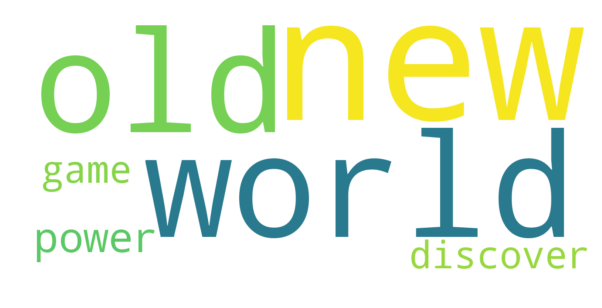

In [20]:
wc.generate(plots_summary_us)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

World, new, old, power, game, discover, man are popular plots elements in US/Canada. The moviegoers there show a great care about the big matters. Also their taste seems to be very masculine, all about power and game. 

<a id='preference_china'></a>

### 2) Preference of China

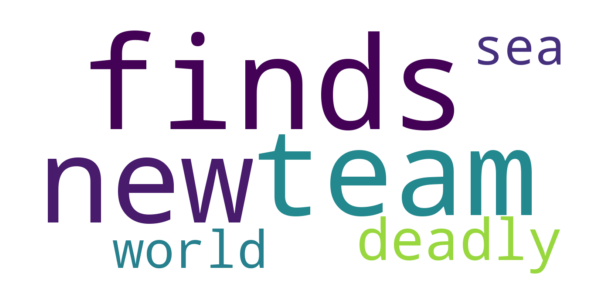

In [21]:
wc.generate(plots_summary_china)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Finds, team, deadly, China, army are among plot elements that pop up in the word cloud of China's top 20 movies' plots summaries. China's moviegoers don't care about world as much as US. But they show more interests on their own country. It seems that they are more teased by tense stories.

<a id='preference_japan'></a>

### 3) Preference of Japan

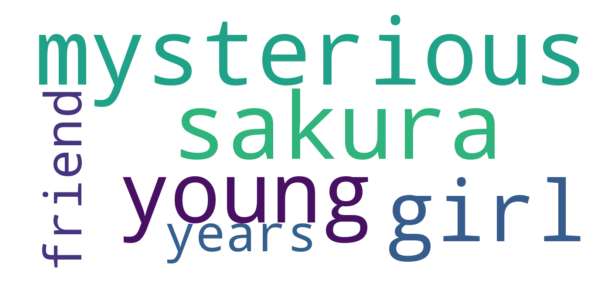

In [22]:
wc.generate(plots_summary_japan)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

Mysterious, sakura, girl, friend are outstandingly popular movie plots in Japan, which is very different from US/Canada and China. It seems that Japanese people not only prefer animation world more to real world they also show a preference on plots about youth, girl, flowers, friends, which are much softer than the other two countries' tastes. Their taste is quite feminine, a total opposite to US/Canada. No wonder Japan is the origin of 'Lolita Fashion'.

<a id='appendix'></a>

## Appendix

<a id='market_share_full'></a>

### Market Share - Full Version with All Countries Shown

In [23]:
df_market_full = pd.read_excel('World_movie_market_2017.xlsx', header=None, names=['country','box_office'])

In [24]:
fig = {
  "data": [
    {
      "values": list(df_market_full['box_office'].values.flatten()),
      "labels": list(df_market_full['country'].values.flatten()),
      "hoverinfo":"label+percent",
        'textinfo':'label+percent',
        'textposition':'outside',
      "hole": .7,
      "type": "pie",
        'sort':False,
        'showlegend':True
    },
    ],
  "layout": {
        "title":"2017 Global Movie Markets Share",

    }
}
    

offline.iplot(fig)

<a id='preference_elements_full'></a>

### Movie Elements Preference - Full Version with Legends

In [26]:
trace = [go.Bar(x=list(df_genre_ratio.loc[df_genre_ratio.genre==genre,country_lis].values.flatten()), 
                y=country_lis, name=genre, orientation = 'h') for genre in genre_lis]
data = trace
layout = go.Layout(title='Preference on Movie Genre by Country', font=dict(size=17),
                   yaxis=dict(title='Country', showline=True, titlefont=dict(size=16), tickfont=dict(size=15)),
                   xaxis=dict(title='Accumulated Ratio of Total Gross', showline=True, 
                              titlefont=dict(size=16), tickfont=dict(size=15), tickformat=".0%"), 
                   legend=dict(font=dict(size=10)),barmode='stack', margin=dict(l=120))


annotations = []

for country in country_lis:
    for i in range(0, len(df_genre_ratio)):
        ratio = df_genre_ratio[country][i]
        genre = df_genre_ratio['genre'][i]
        if ratio>0.07:
            x = df_genre_ratio[country][0:i+1].sum()-0.05
            text = df_genre_ratio['genre'][i]
            annotations.append(dict(x=x, y=country, text=text,
                                  font=dict(family='Calibri', size=17,
                                  color='rgba(245, 246, 249, 1)'),
                                  showarrow=False))
layout['annotations'] = annotations
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)